## Imports

In [163]:
import pandas as pd
import math
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from tqdm import tqdm_notebook as tqdm
from boruta import BorutaPy
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import warnings

## Data Read-in

In [34]:
probes = pd.read_csv('probes.csv',sep='\t', encoding='utf-8', header=None)
probes.columns = ['id','created_at','updated_at','deleted_at','timestamp',
                  'user_id','answer','page_nr','delay_time','time_to_answer']


questionnaires = pd.DataFrame(columns=['id','created_at','updated_at','deleted_at','screen_width',
                                      'screen_height','age','gender','level_of_education',
                                      'using_mouse','read_war_and_peace','read_grimm'])
# For some reason only 12 columns for 13 categories?
with open('questionnaires.csv','r',encoding='utf-8') as f:
    for line in f:
        spl = line[1:-2].split('\t')
        questionnaires = questionnaires.append(pd.DataFrame(np.array(spl).reshape(1,-1),columns=['id','created_at','updated_at','deleted_at','screen_width',
                                      'screen_height','age','gender','level_of_education',
                                      'using_mouse','read_war_and_peace','read_grimm']))

questions = pd.read_csv('questions.csv',sep='\t', encoding='utf-8', header=None)
questions.columns = ['id','created_at','updated_at','deleted_at','user_id',
                     'correct','page_nr','book']

records = pd.read_csv('records.csv',sep='\t', encoding='utf-8', header=None)
records.columns= ['id','created_at','updated_at', 'deleted_at','timestamp','user_id',
                 'clicked_left', 'clicked_right','on_screen','screen_loc','x','y',
                 'screen_width','screen_height']

## Some relevant statistics

In [52]:
labels = np.array([0 if val.answer in [1,2] else 1 for _,val in probes.iterrows()])

_,count = np.unique(labels,return_counts=True)
percs = np.round(count/np.sum(count)*100,1)
print("{}% not mindwandering, {}% mindwandering".format(percs[0], percs[1]))

# users who did not finish the experiment
usrs_all = np.unique(probes.user_id)
blacklist = usrs_all[np.array([len(probes.user_id.loc[probes.user_id==usr]) for usr in usrs_all])<6]
print("# users who started experiment: {}, # users who finished experiment: {}".format(len(usrs_all), len(usrs_all)-len(blacklist)))

usrs = np.array([x for x in usrs_all if x not in blacklist and not np.isnan(x)])

tol_gr = []
for us_idx in usrs:
    tol_gr.append(0 if questions.loc[questions.user_id==us_idx,'correct'].iloc[0] == 'war_and_peace' else 1)

_,prop_texts = np.unique(tol_gr, return_counts=True)
print('# valid users read war and peace: {}, # valid who read Grimm: {}'.format(prop_texts[0], prop_texts[1]))



71.4% not mindwandering, 28.6% mindwandering
# users who started experiment: 29, # users who finished experiment: 24
# valid users read war and peace: 14, # valid who read Grimm: 10


## Processing pipe

In [173]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def _normalize_coords(self, df):
        df['x_norm'] = df.x/df.screen_width
        df['y_norm'] = df.y/df.screen_height
        loc_norm = []
        for usr in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==usr]
            loc_norm = loc_norm+list(df_usr.screen_loc/df_usr.screen_loc.max())
        df['loc_norm'] = loc_norm
        return df

    def _get_polar(self, df):
        df['cur_polar'] = np.arctan2(list(df.y_norm),list(df.x_norm))
        df['cur_velocity'] = np.sqrt(list(df.x_norm**2 + df.y_norm**2))
        return df

    def _get_trajectories(self,df):
        traj_loc = []
        traj_cur =  []
        for usr in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==usr]
            traj_loc = traj_loc + list(df_usr.loc_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True))
            traj_cur = traj_cur + list(np.arctan2(df_usr.x_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True),
                                                  df_usr.y_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True)))
        df['traj_loc'] = traj_loc
        df['traj_cur'] = traj_cur
        return df
    
    def _get_hesitation(self,df):
        hesitation = []
        for user in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==user].sort_values('id')
            timepts = pd.to_datetime(df_usr.timestamp)
            a = pd.to_datetime([np.nan]+list(df_usr.timestamp))
            b = pd.to_datetime(list(df_usr.timestamp)+[np.nan])
            c = list((b-a).seconds)
            hesitation = hesitation + c[:-1]
        df['hesitation'] = hesitation
        return df
    
    def _slice_probe_windows(self, df):
        # interval length = 30 seconds
        intervals = []
        for _,probe in probes.iterrows():
            FMT = '%Y-%m-%d %H:%M:%S'
            ts = pd.Timestamp(probe.timestamp)
            usr = probe.user_id
            if usr in np.unique(df.user_id):
                ts_int = pd.Interval(ts-pd.Timedelta(30,unit='seconds'),ts,closed='both')
                # Get cumulative clicks
                df_int = df.loc[np.logical_and(df.user_id==usr,
                                               [x in ts_int for x in pd.to_datetime(df.timestamp)])].copy()
                df_int['lclick_cumu'] = [df_int.clicked_left.sum()]*len(df_int)
                df_int['rclick_cumu'] = [df_int.clicked_right.sum()]*len(df_int)
                # if empty slice (only on invalid subjects)
                try:
                    df_int['spec'] = [np.mean(np.abs(np.fft.fft(df_int.cur_velocity)))]*len(df_int)
                except ValueError:
                    print('WARNING EMPTY SLICE')
                    df_int['spec'] = [0]*len(df_int)
                intervals.append(df_int[['x_norm','y_norm','loc_norm','cur_polar','cur_velocity','hesitation',
                                        'traj_loc','traj_cur',
#                                          'lclick_cumu','rclick_cumu','spec'
                                        ]])
        return intervals
    
    def _average_windows(self, df):
        res_mat = pd.DataFrame(columns=df[0].columns)
        for interv in df:
            res_mat = res_mat.append(pd.DataFrame(np.array(interv.mean()).reshape(1,len(df[0].columns)),
                                                  columns=df[0].columns))
        return res_mat
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        res_mat = X.copy()
        res_mat = self._normalize_coords(res_mat)
        res_mat = self._get_polar(res_mat)
        res_mat = self._get_trajectories(res_mat)
        res_mat = self._get_hesitation(res_mat)
        res_mat = self._slice_probe_windows(res_mat)
        res_mat = self._average_windows(res_mat)
        return np.array(res_mat)

## Do analysis

In [174]:
# Convergence warning and only 1 label found in test warning
#warnings.filterwarnings("ignore")

prec, rec, f1 = [],[],[]
prec_rand, rec_rand, f1_rand = [],[],[]

idx = 0
kf = KFold(n_splits=12)
for train, test in tqdm(kf.split(usrs)):
#     print('Fold nr: {}/{}, )
    X_train = records.loc[[x in usrs[train] for x in records.user_id]]
    X_test = records.loc[[x in usrs[test] for x in records.user_id]]
    y_train = labels[[x in usrs[train] for x in probes.user_id]]
    y_test = labels[[x in usrs[test] for x in probes.user_id]]
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    pipe = Pipeline(steps = [('preprocessing', Preprocessor()),#])
                             #('feat_select', BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)),
                             ('clf', RandomForestClassifier(n_estimators=10,n_jobs=-1, class_weight='balanced', max_depth=5))]).fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    idx+=1
    clrp = classification_report(y_test,y_pred, output_dict=True)
    clrp_random = classification_report(y_test, np.random.rand(len(y_test))<0.5,output_dict=True)
    f1.append(round(clrp['macro avg']['f1-score'],3))
    prec.append(round(clrp['macro avg']['precision'],3))
    rec.append(round(clrp['macro avg']['recall'],3))
    clrp_random = classification_report(y_test, np.random.rand(len(y_test))<0.5,output_dict=True)
    f1_rand.append(round(clrp_random['macro avg']['f1-score'],3))
    prec_rand.append(round(clrp_random['macro avg']['precision'],3))
    rec_rand.append(round(clrp_random['macro avg']['recall'],3))
    print('Left-out subjects:{}, F1-score:{}, Precision:{}, Recall:{}'.format(usrs[test],f1[-1],prec[-1],rec[-1]))
print('Average F1:{}, average Precision: {}, average Recall: {}'.format(round(np.mean(f1),3), 
                                                                        round(np.mean(prec),3), 
                                                                        round(np.mean(rec),3)))

print('Random baseline: F1:{}, precision:{}, recall:{}'.format(round(np.mean(f1_rand),3), 
                                                               round(np.mean(prec_rand),3), 
                                                               round(np.mean(rec_rand),3)))

Left-out subjects:[2. 3.], F1-score:0.58, Precision:0.625, Recall:0.614
Left-out subjects:[4. 5.], F1-score:0.4, Precision:0.4, Recall:0.4
Left-out subjects:[6. 7.], F1-score:0.429, Precision:0.409, Recall:0.45
Left-out subjects:[ 9. 10.], F1-score:0.567, Precision:0.614, Recall:0.569
Left-out subjects:[11. 14.], F1-score:0.7, Precision:0.909, Recall:0.667
Left-out subjects:[15. 16.], F1-score:0.7, Precision:0.7, Recall:0.7
Left-out subjects:[17. 18.], F1-score:0.625, Precision:0.667, Recall:0.629
Left-out subjects:[19. 22.], F1-score:0.556, Precision:0.611, Recall:0.583
Left-out subjects:[23. 24.], F1-score:0.576, Precision:0.846, Recall:0.6
Left-out subjects:[25. 26.], F1-score:0.455, Precision:0.455, Recall:0.455


C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\class

Left-out subjects:[27. 30.], F1-score:0.368, Precision:0.5, Recall:0.292
Left-out subjects:[32. 33.], F1-score:0.496, Precision:0.5, Recall:0.5
Average F1:0.538, average Precision: 0.603, average Recall: 0.538
Random baseline: F1:0.445, precision:0.485, recall:0.502


C:\Users\fwalo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'f1-score')

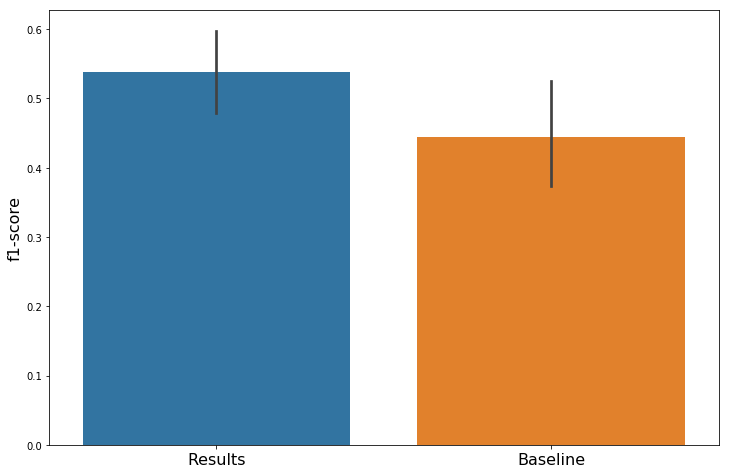

In [181]:
import seaborn as sns
res = pd.DataFrame()
res['Results'] = f1
res['Baseline'] = f1_rand
plt.figure(figsize=(12,8))
plt.xticks(fontsize=16)
sns.barplot(data=res)
plt.ylabel('f1-score',fontsize=16)

In [188]:
import scipy 

res = scipy.stats.ttest_rel(f1,f1_rand)
# since 1 sided
print('Significance? p={}'.format(round(res.pvalue/2,4)))

Significance? p=0.0509
